In [ ]:
# Krok 1: Instalacja wymaganych bibliotek
!pip install datasets transformers torch torchvision accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Krok 2: Import niezbędnych modułów
from datasets import load_dataset
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
import matplotlib.pyplot as plt

# Sprawdzenie dostępności GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Krok 3: Ładowanie i przygotowanie datasetu
dataset = load_dataset("Bingsu/Cat_and_Dog")

# Definicja transformacji obrazów
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Funkcja przetwarzająca przykłady
def preprocess(examples):
    examples['image'] = [transform(image.convert("RGB")) for image in examples['image']]
    return examples

# Przetwarzanie danych
dataset = dataset.map(preprocess, batched=True, batch_size=64)

# Podział na treningowe i testowe
dataset.set_format(type='torch', columns=['image', 'labels'])
train_dataset = dataset['train']
test_dataset = dataset['test']

# Tworzenie DataLoaderów
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
print(len(train_dataset))

8000


In [ ]:
# Krok 4: Definicja modelu
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 klasy: kot i pies
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


In [ ]:
# Krok 5: Definicja funkcji straty i optymalizatora
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Krok 6: Trening modelu
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs = data['image'].to(device)
        labels = data['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 0:
            print(f'Epoch: {epoch+1}, Batch: {i+1}, Loss: {running_loss/50:.4f}')
            running_loss = 0.0

Epoch: 1, Batch: 1, Loss: 0.0145
Epoch: 1, Batch: 11, Loss: 0.0616
Epoch: 1, Batch: 21, Loss: 0.0673
Epoch: 1, Batch: 31, Loss: 0.0357
Epoch: 1, Batch: 41, Loss: 0.0295
Epoch: 1, Batch: 51, Loss: 0.0266
Epoch: 1, Batch: 61, Loss: 0.0226
Epoch: 1, Batch: 71, Loss: 0.0255
Epoch: 1, Batch: 81, Loss: 0.0291
Epoch: 1, Batch: 91, Loss: 0.0247
Epoch: 1, Batch: 101, Loss: 0.0306
Epoch: 1, Batch: 111, Loss: 0.0268
Epoch: 1, Batch: 121, Loss: 0.0200
Epoch: 2, Batch: 1, Loss: 0.0013
Epoch: 2, Batch: 11, Loss: 0.0137
Epoch: 2, Batch: 21, Loss: 0.0172
Epoch: 2, Batch: 31, Loss: 0.0151
Epoch: 2, Batch: 41, Loss: 0.0129
Epoch: 2, Batch: 51, Loss: 0.0122
Epoch: 2, Batch: 61, Loss: 0.0135
Epoch: 2, Batch: 71, Loss: 0.0242
Epoch: 2, Batch: 81, Loss: 0.0216
Epoch: 2, Batch: 91, Loss: 0.0212
Epoch: 2, Batch: 101, Loss: 0.0166
Epoch: 2, Batch: 111, Loss: 0.0104
Epoch: 2, Batch: 121, Loss: 0.0184
Epoch: 3, Batch: 1, Loss: 0.0016
Epoch: 3, Batch: 11, Loss: 0.0133
Epoch: 3, Batch: 21, Loss: 0.0156
Epoch: 3, B

In [ ]:
# Krok 7: Ewaluacja modelu
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images = data['image'].to(device)
        labels = data['labels'].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 95.10%


In [ ]:
# Krok 8: Funkcja do predykcji własnych obrazów
def predict_image(image_path):
    # Przetwarzanie obrazu
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Predykcja
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)

    # Interpretacja wyników
    classes = ['cat', 'dog']
    predicted_class = classes[torch.argmax(probabilities).item()]
    confidence = torch.max(probabilities).item()

    # Wyświetlanie wyników
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Predicted: {predicted_class} ({confidence:.2f})')
    plt.show()

Saving Lady_with_an_Ermine_-_Leonardo_da_Vinci_-_Google_Art_Project.jpg to Lady_with_an_Ermine_-_Leonardo_da_Vinci_-_Google_Art_Project.jpg


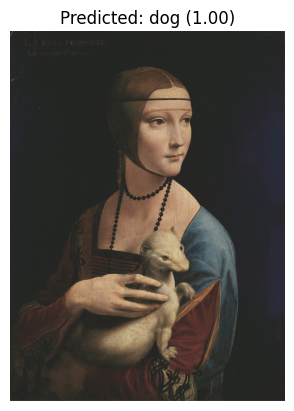

In [ ]:
from google.colab import files
uploaded = files.upload()
for filename in uploaded.keys():
    predict_image(filename)